# Note before running 


# Import libraries 

In [13]:
import numpy as np
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Dense, MaxPool2D, Conv2D, Flatten, Dropout, BatchNormalization
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input
from keras import regularizers
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.utils import class_weight
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings
import collections
import pandas as pd
from collections import Counter
from keras.applications.vgg16 import VGG16
warnings.simplefilter(action='ignore', category = FutureWarning)
%matplotlib inline

In [14]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


In [15]:
train_path= 'train'
valid_path = 'valid'
test_path = 'test'
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input).flow_from_directory(directory=train_path, target_size=(224,224), classes=['health','one','two','unused'],batch_size=10)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input).flow_from_directory(directory=test_path, target_size=(224,224), classes=['health','one','two','unused'],batch_size=10,shuffle=False)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input).flow_from_directory(directory=valid_path, target_size=(224,224), classes=['health','one','two','unused'],batch_size=10)
imgs, labels = next(train_batches)

Found 4123 images belonging to 4 classes.
Found 833 images belonging to 4 classes.
Found 918 images belonging to 4 classes.


# Helper functions 

In [16]:
# PLOT IMAGES 
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10,figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr , axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [17]:
# PLOT CONFUSION MATRIX
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

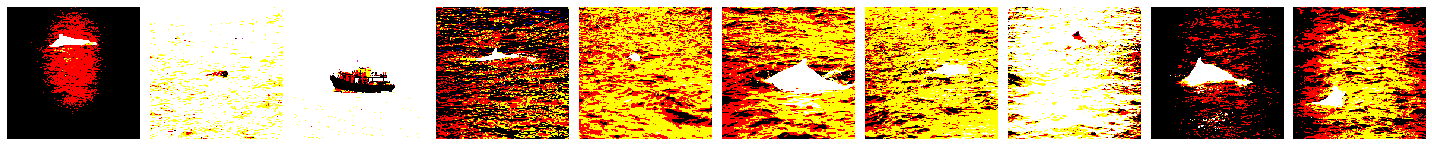

[[0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]]


In [18]:
# check if data is loaded 
plotImages(imgs)
print(labels)

# load trained model 

## load model-1

In [19]:
model_1 = keras.models.load_model('results/resnet2_one_unused_augmented.h5')
model_1.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
_______________________________________________________________________________________

# plot confusion matrix

Confusion matrix, without normalization
[[420   0  31   6]
 [ 17  17  55   0]
 [ 56   3 180   0]
 [  1   0   0  47]]


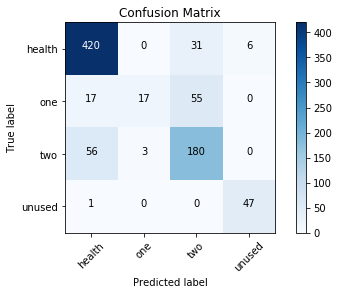

In [20]:
predictions = model_1.predict(x=test_batches, verbose=0)
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1))
cm_plot=['health','one','two','unused']
plot_confusion_matrix(cm=cm, classes=cm_plot, title='Confusion Matrix')

In [21]:
print('0: Health , 1: One , 2: Two , 3: Unused')
predictions = model_1.predict(x=test_batches, verbose=0)
ytest= test_batches.classes
ypredict = np.argmax(predictions,axis=-1)
print(classification_report(ytest,ypredict))

0: Health , 1: One , 2: Two , 3: Unused
              precision    recall  f1-score   support

           0       0.85      0.92      0.88       457
           1       0.85      0.19      0.31        89
           2       0.68      0.75      0.71       239
           3       0.89      0.98      0.93        48

    accuracy                           0.80       833
   macro avg       0.82      0.71      0.71       833
weighted avg       0.80      0.80      0.78       833



# model-2


In [22]:
model_2 = keras.models.load_model("results/resnet_final.h5")
model_2.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten_5 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dense_20 (Dense)             (None, 500)               50176500  
_________________________________________________________________
batch_normalization_17 (Batc (None, 500)               2000      
_________________________________________________________________
dropout_15 (Dropout)         (None, 500)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 300)               150300    
_________________________________________________________________
batch_normalization_18 (Batc (None, 300)             

Confusion matrix, without normalization
[[398   1  44  14]
 [ 12  19  58   0]
 [ 40   9 190   0]
 [  0   0   0  48]]


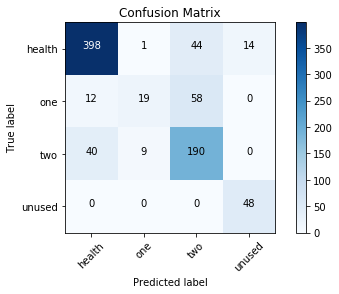

In [23]:
predictions = model_2.predict(x=test_batches, verbose=0)
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1))
cm_plot=['health','one','two','unused']
plot_confusion_matrix(cm=cm, classes=cm_plot, title='Confusion Matrix')

In [24]:
print('0: Health , 1: One , 2: Two , 3: Unused')
predictions = model_2.predict(x=test_batches, verbose=0)
ytest= test_batches.classes
ypredict = np.argmax(predictions,axis=-1)
print(classification_report(ytest,ypredict))

0: Health , 1: One , 2: Two , 3: Unused
              precision    recall  f1-score   support

           0       0.88      0.87      0.88       457
           1       0.66      0.21      0.32        89
           2       0.65      0.79      0.72       239
           3       0.77      1.00      0.87        48

    accuracy                           0.79       833
   macro avg       0.74      0.72      0.70       833
weighted avg       0.79      0.79      0.77       833

